# НОУТБУК 1: ПОДГОТОВКА ДАННЫХ (person-weapon-v2)
 Этот ноутбук выполняет:
 1. Загрузку датасета с Roboflow API (person-weapon-v2)
 2. Преобразование в формат YOLO
 3. Анализ статистики классов
 4. Split на train/val/test (70/15/15)
 5. Визуализацию примеров


In [2]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
import json
import shutil
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("=" * 70)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ YOLOv8 (person-weapon-v2)")
print("=" * 70)


ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ YOLOv8 (person-weapon-v2)


# ЧАСТЬ 1: СОЗДАНИЕ ДИРЕКТОРИЙ

In [3]:

BASE_DIR = Path('data')
BASE_DIR.mkdir(exist_ok=True)

RAW_DIR = BASE_DIR / 'raw'
PROCESSED_DIR = BASE_DIR / 'processed'
ANNOTATIONS_DIR = BASE_DIR / 'annotations'

RAW_DIR.mkdir(exist_ok=True)
PROCESSED_DIR.mkdir(exist_ok=True)
ANNOTATIONS_DIR.mkdir(exist_ok=True)

print("\nДиректории созданы успешно\n")


Директории созданы успешно



# ЧАСТЬ 2: ОПРЕДЕЛЕНИЕ КЛАССОВ

In [4]:
print("=" * 70)
print("ОПРЕДЕЛЕНИЕ КЛАССОВ ДАТАСЕТА person-weapon-v2")
print("=" * 70 + "\n")

# Все 5 классов из датасета
ALL_CLASSES = {
    'grenade': 0,
    'knife': 1,
    'pistol': 2,
    'rifle': 3,
    'person': 4
}

# Классы оружия (для определения браконьеров)
WEAPON_CLASSES = {0, 1, 2, 3}  # grenade, knife, pistol, rifle
PERSON_CLASS = 4

print("Все классы датасета:")
for name, idx in sorted(ALL_CLASSES.items(), key=lambda x: x[1]):
    if idx in WEAPON_CLASSES:
        print(f"   {idx}: {name} [ОРУЖИЕ]")
    else:
        print(f"   {idx}: {name} [ЧЕЛОВЕК]")

print(f"\nЛогика определения браконьера:")
print(f"   На фото присутствует Person (класс 4)")
print(f"   И одновременно присутствует оружие (классы 0, 1, 2, 3)")


ОПРЕДЕЛЕНИЕ КЛАССОВ ДАТАСЕТА person-weapon-v2

Все классы датасета:
   0: grenade [ОРУЖИЕ]
   1: knife [ОРУЖИЕ]
   2: pistol [ОРУЖИЕ]
   3: rifle [ОРУЖИЕ]
   4: person [ЧЕЛОВЕК]

Логика определения браконьера:
   На фото присутствует Person (класс 4)
   И одновременно присутствует оружие (классы 0, 1, 2, 3)


# ЧАСТЬ 3: ЗАГРУЗКА ДАННЫХ С ROBOFLOW

In [8]:

print("\n" + "=" * 70)
print("ЗАГРУЗКА ДАТАСЕТА С ROBOFLOW")
print("=" * 70 + "\n")

try:
    from roboflow import Roboflow
    print("Roboflow уже установлена")
except ImportError:
    print("Установка Roboflow...")
    os.system('pip install roboflow -q')
    from roboflow import Roboflow
    print("Roboflow установлена")

API_KEY = 'YOUR_ROBOFLOW_API_KEY'  # Заменить на реальный ключ

if API_KEY != 'YOUR_ROBOFLOW_API_KEY':
    print(f"\nИнициализация Roboflow...")
    try:
        rf = Roboflow(api_key=API_KEY)
        # Загрузить person-weapon-v2 датасет
        project = rf.workspace('ksdjflaskjf').project('person-weapon-v2')
        dataset = project.version(2).download(model_format='yolov8', location=str(RAW_DIR), overwrite=True)
        print(f"Датасет person-weapon-v2 загружен в {RAW_DIR}\n")
    except Exception as e:
        print(f"Ошибка при загрузке: {e}")
        print("Используйте локальные данные или установите правильный ключ\n")
else:
    print("API ключ не установлен. Используем локальные данные...\n")



ЗАГРУЗКА ДАТАСЕТА С ROBOFLOW

Roboflow уже установлена

Инициализация Roboflow...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to data\raw in yolov8:: 100%|██████████| 7528/7528 [00:03<00:00, 2451.47it/s]


Датасет person-weapon-v2 загружен в data\raw



# ЧАСТЬ 4: АНАЛИЗ СТРУКТУРЫ ДАННЫХ

In [9]:
print("=" * 70)
print("АНАЛИЗ СТРУКТУРЫ ДАННЫХ")
print("=" * 70 + "\n")

images_path = RAW_DIR /'train' / 'images'
labels_path = RAW_DIR / 'train'/'labels'

image_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}

if images_path.exists() and labels_path.exists():
    image_files = sorted([f for f in images_path.iterdir()
                          if f.suffix in image_extensions])
    label_files = sorted([f for f in labels_path.iterdir() if f.suffix == '.txt'])

    print(f"Найдено изображений: {len(image_files)}")
    print(f"Найдено аннотаций: {len(label_files)}")
    print(f"Пары изображение-аннотация: {min(len(image_files), len(label_files))}\n")
else:
    print("️Структура папок не найдена")
    image_files = []
    label_files = []


АНАЛИЗ СТРУКТУРЫ ДАННЫХ

Найдено изображений: 3761
Найдено аннотаций: 3761
Пары изображение-аннотация: 3761



In [10]:
# ============================================================================
# ЧАСТЬ 5: АНАЛИЗ КЛАССОВ И ОПРЕДЕЛЕНИЕ БРАКОНЬЕРОВ
# ============================================================================

print("=" * 70)
print("АНАЛИЗ КЛАССОВ И ОПРЕДЕЛЕНИЕ БРАКОНЬЕРОВ")
print("=" * 70 + "\n")
class_counts = {i: 0 for i in range(5)}
annotation_stats = []
poacher_images = []  # Изображения с браконьерами
person_only_images = []  # Только люди без оружия
weapon_only_images = []  # Только оружие без людей

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        annotation_stats.append(len(lines))

        classes_in_image = set()
        for line in lines:
            try:
                class_id = int(line.split()[0])
                if class_id < 5:
                    class_counts[class_id] += 1
                    classes_in_image.add(class_id)
            except (IndexError, ValueError):
                continue

        # Определить тип изображения
        has_person = PERSON_CLASS in classes_in_image
        has_weapon = any(w in classes_in_image for w in WEAPON_CLASSES)

        img_name = label_file.stem
        if has_person and has_weapon:
            poacher_images.append(img_name)
        elif has_person and not has_weapon:
            person_only_images.append(img_name)
        elif not has_person and has_weapon:
            weapon_only_images.append(img_name)

print("📊 Статистика классов:")
total_objects = sum(class_counts.values())
for class_id, name in sorted([(v, k) for k, v in ALL_CLASSES.items()]):
    count = class_counts[class_id]
    percentage = (count / total_objects * 100) if total_objects > 0 else 0
    print(f"   {class_id}: {name:10s} — {count:4d} объектов ({percentage:5.1f}%)")

print(f"\nАнализ типов изображений:")
print(f"   Браконьеры (Person + Оружие): {len(poacher_images)} ({len(poacher_images)/len(label_files)*100:.1f}%)")
print(f"   Только люди: {len(person_only_images)} ({len(person_only_images)/len(label_files)*100:.1f}%)")
print(f"   Только оружие: {len(weapon_only_images)} ({len(weapon_only_images)/len(label_files)*100:.1f}%)")

if annotation_stats:
    print(f"\n📈 Статистика аннотаций на изображение:")
    print(f"   Среднее: {np.mean(annotation_stats):.2f}")
    print(f"   Мин: {np.min(annotation_stats)}")
    print(f"   Макс: {np.max(annotation_stats)}\n")


АНАЛИЗ КЛАССОВ И ОПРЕДЕЛЕНИЕ БРАКОНЬЕРОВ

📊 Статистика классов:
   0: grenade    — 1413 объектов ( 20.9%)
   1: knife      —  845 объектов ( 12.5%)
   2: pistol     — 1010 объектов ( 15.0%)
   3: rifle      — 1227 объектов ( 18.2%)
   4: person     — 2257 объектов ( 33.4%)

Анализ типов изображений:
   Браконьеры (Person + Оружие): 1440 (38.3%)
   Только люди: 0 (0.0%)
   Только оружие: 2321 (61.7%)

📈 Статистика аннотаций на изображение:
   Среднее: 1.80
   Мин: 1
   Макс: 15



# ЧАСТЬ 6: ВИЗУАЛИЗАЦИЯ

ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ



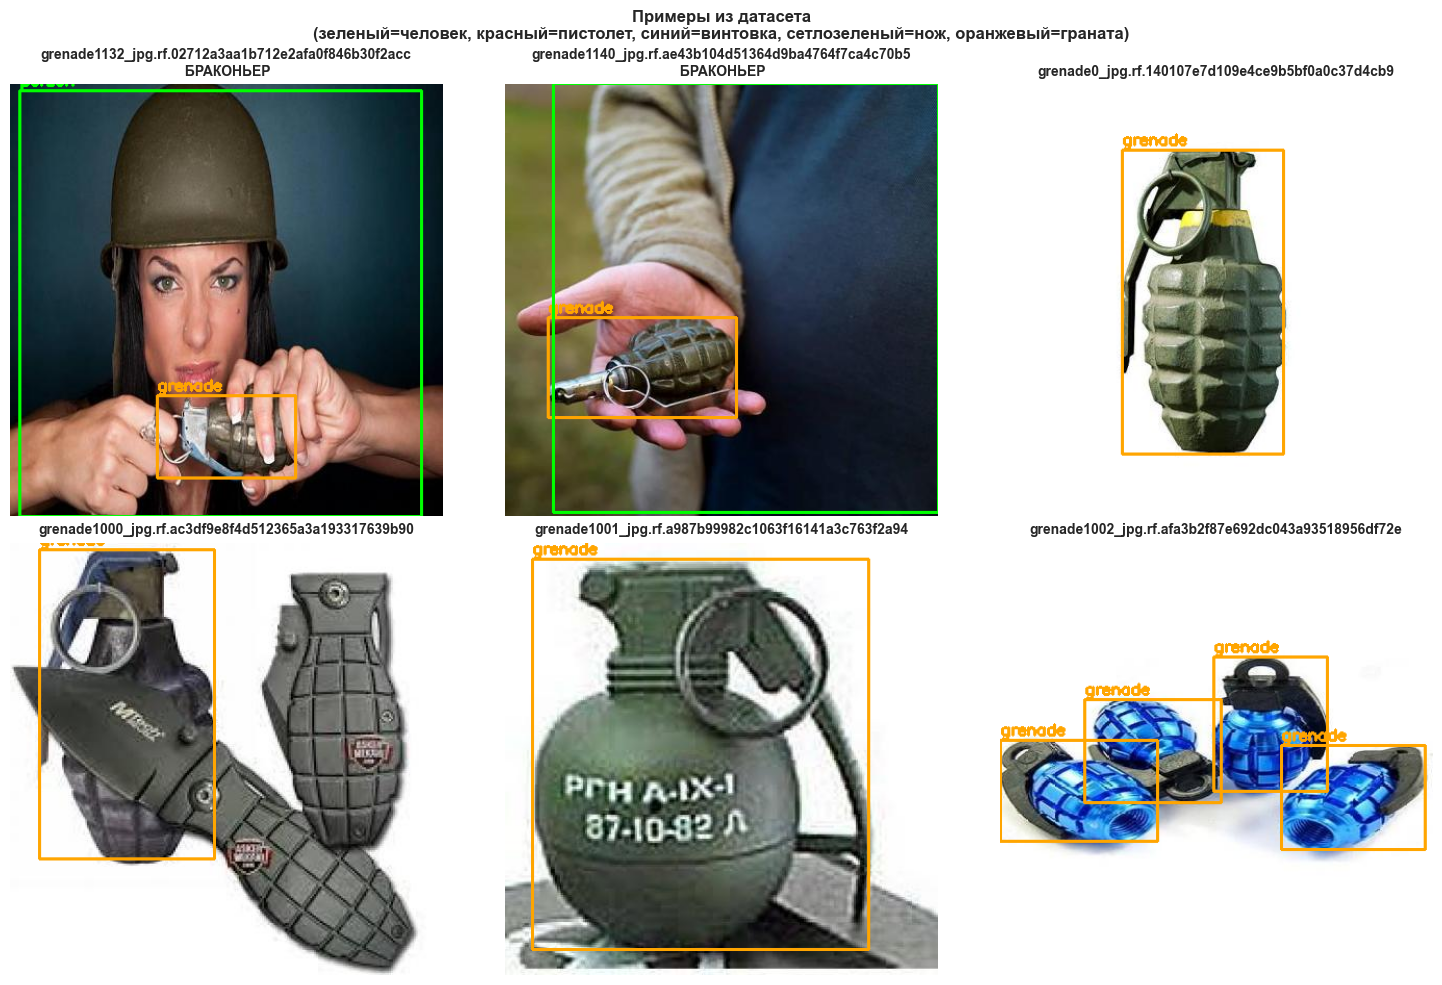

Примеры визуализированы



In [13]:
def draw_yolo_boxes(image_path, label_path, all_classes):
    """
    Нарисовать bounding boxes на изображении.
    """
    image = cv2.imread(str(image_path))
    if image is None:
        return None

    height, width = image.shape[:2]

    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Цвета для разных классов
        colors = {
            0: (0, 165, 255),  # grenade - оранжевый
            1: (0, 255, 255),  # knife - жёлтый
            2: (0, 0, 255),    # pistol - красный
            3: (255, 0, 0),    # rifle - синий
            4: (0, 255, 0)     # person - зелёный
        }

        # Словарь названий для букв на английском
        class_names_en = {v: k for k, v in all_classes.items()}

        for line in lines:
            try:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                box_width = float(parts[3]) * width
                box_height = float(parts[4]) * height

                x1 = int(x_center - box_width / 2)
                y1 = int(y_center - box_height / 2)
                x2 = int(x_center + box_width / 2)
                y2 = int(y_center + box_height / 2)

                color = colors.get(class_id, (255, 255, 255))
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                class_name = class_names_en.get(class_id, 'Unknown')
                cv2.putText(image, class_name, (x1, y1 - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            except (IndexError, ValueError):
                continue

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("=" * 70)
print("ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ")
print("=" * 70 + "\n")

# Выбрать примеры разных типов
n_examples = min(6, len(image_files))
examples_to_show = []

# Взять примеры браконьеров (если есть)
if poacher_images:
    examples_to_show.extend(poacher_images[:2])

# Взять примеры только людей
if person_only_images:
    examples_to_show.extend(person_only_images[:2])

# Взять случайные примеры
remaining = n_examples - len(examples_to_show)
all_img_names = [f.stem for f in image_files]
random_examples = [img for img in all_img_names if img not in examples_to_show][:remaining]
examples_to_show.extend(random_examples)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_name in enumerate(examples_to_show[:6]):
    img_path = images_path / f"{img_name}{image_files[0].suffix}"
    label_path = labels_path / f"{img_name}.txt"

    annotated_img = draw_yolo_boxes(img_path, label_path, ALL_CLASSES)

    if annotated_img is not None:
        # Определить тип
        classes_in_img = set()
        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    classes_in_img.add(int(line.split()[0]))

        has_person = PERSON_CLASS in classes_in_img
        has_weapon = any(w in classes_in_img for w in WEAPON_CLASSES)

        if has_person and has_weapon:
            title = f'{img_name}\n БРАКОНЬЕР'
        elif has_person:
            title = f'{img_name}\n Человек'
        else:
            title = f'{img_name}'

        axes[idx].imshow(annotated_img)
        axes[idx].set_title(title, fontsize=10, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Примеры из датасета\n(зеленый=человек, красный=пистолет, синий=винтовка, сетлозеленый=нож, оранжевый=граната)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
print("Примеры визуализированы\n")


# ЧАСТЬ 7: ГРАФИКИ СТАТИСТИКИ

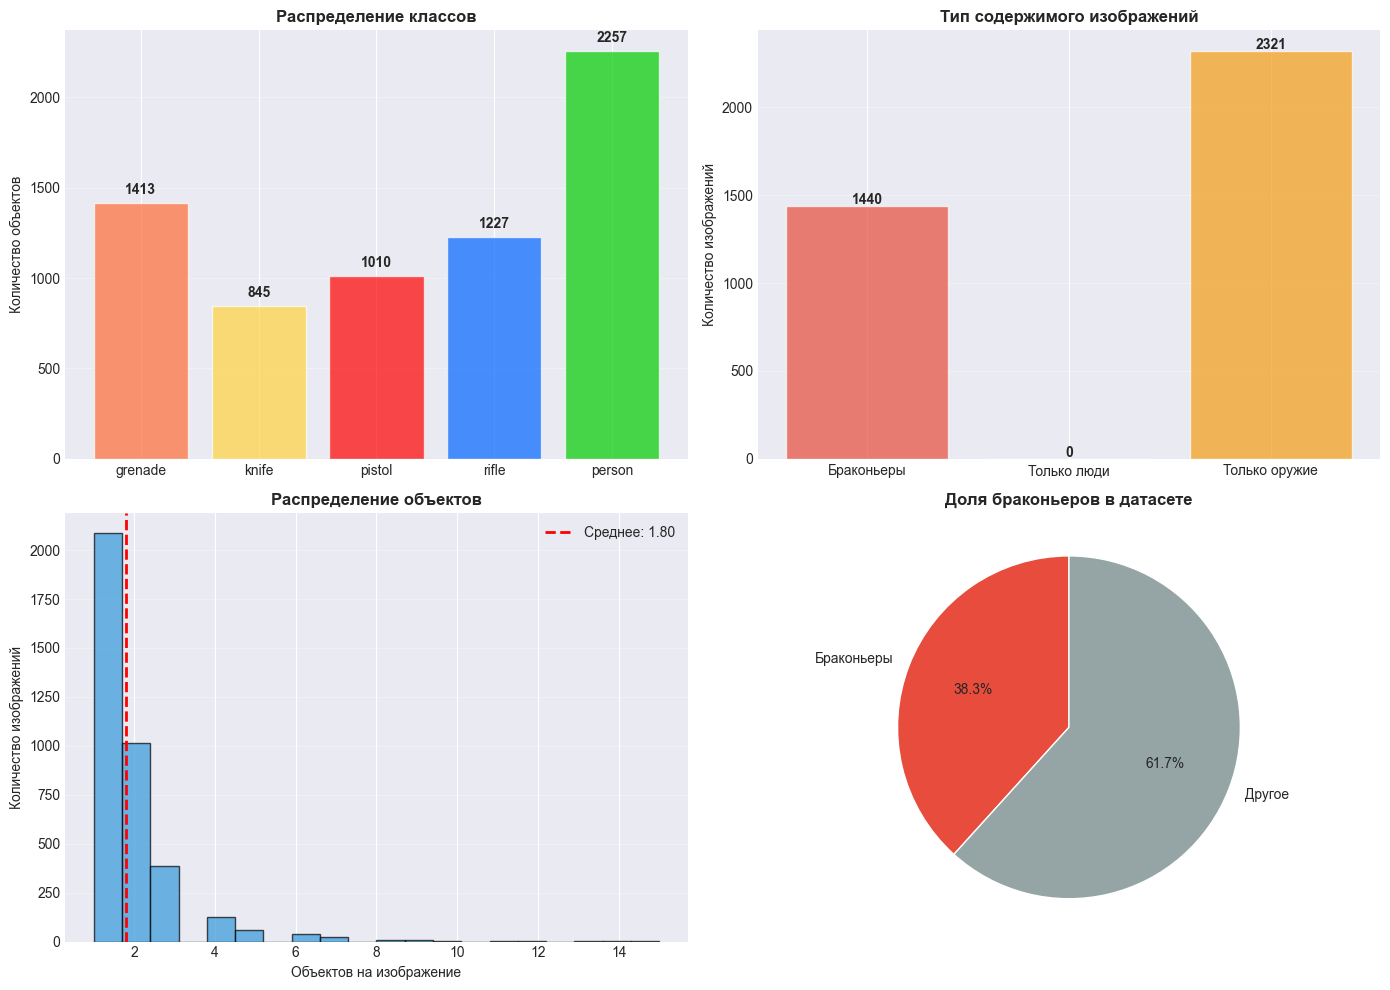

Графики созданы



In [15]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Распределение классов
class_names_list = [ALL_CLASSES for ALL_CLASSES in sorted([(v, k) for k, v in ALL_CLASSES.items()])]
class_names_list = [name for idx, name in sorted([(ALL_CLASSES[k], k) for k in ALL_CLASSES])]
counts = [class_counts[i] for i in range(5)]

colors_bar = ['#FF6B35', '#FFD23F', '#FF0000', '#0066FF', '#00CC00']
axes[0, 0].bar(class_names_list, counts, color=colors_bar, alpha=0.7)
axes[0, 0].set_ylabel('Количество объектов')
axes[0, 0].set_title('Распределение классов', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (name, count) in enumerate(zip(class_names_list, counts)):
    axes[0, 0].text(i, count + 50, str(count), ha='center', fontweight='bold')

# График 2: Типы изображений
types = ['Браконьеры', 'Только люди', 'Только оружие']
values = [len(poacher_images), len(person_only_images), len(weapon_only_images)]
axes[0, 1].bar(types, values, color=['#e74c3c', '#3498db', '#f39c12'], alpha=0.7)
axes[0, 1].set_ylabel('Количество изображений')
axes[0, 1].set_title('Тип содержимого изображений', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    axes[0, 1].text(i, v + 10, str(v), ha='center', fontweight='bold')

# График 3: Распределение объектов на изображение
axes[1, 0].hist(annotation_stats, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Объектов на изображение')
axes[1, 0].set_ylabel('Количество изображений')
axes[1, 0].set_title('Распределение объектов', fontweight='bold')
axes[1, 0].axvline(np.mean(annotation_stats), color='red', linestyle='--', linewidth=2,
                   label=f'Среднее: {np.mean(annotation_stats):.2f}')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Доля браконьеров
poacher_percentage = len(poacher_images) / len(label_files) * 100
other_percentage = (len(person_only_images) + len(weapon_only_images)) / len(label_files) * 100

axes[1, 1].pie([poacher_percentage, other_percentage],
               labels=['Браконьеры', 'Другое'],
               colors=['#e74c3c', '#95a5a6'],
               autopct='%1.1f%%',
               startangle=90)
axes[1, 1].set_title('Доля браконьеров в датасете', fontweight='bold')

plt.tight_layout()
plt.show()
print("Графики созданы\n")


# ЧАСТЬ 8: SPLIT НА TRAIN/VAL/TEST

In [16]:

print("=" * 70)
print("SPLIT ДАТАСЕТА (70/15/15)")
print("=" * 70 + "\n")

if len(image_files) > 0:
    YOLO_DIR = PROCESSED_DIR / 'yolo_format'
    YOLO_DIR.mkdir(exist_ok=True)

    splits = ['train', 'val', 'test']
    for split in splits:
        (YOLO_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
        (YOLO_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

    # Стратифицированный split для сохранения баланса браконьеров
    all_img_names = [f.stem for f in image_files]

    # Разделить на браконьеров и остальных
    poacher_list = list(poacher_images)
    other_list = [img for img in all_img_names if img not in poacher_list]

    # Split браконьеров
    p_train, p_temp = train_test_split(poacher_list, test_size=0.3, random_state=42)
    p_val, p_test = train_test_split(p_temp, test_size=0.5, random_state=42)

    # Split остальных
    o_train, o_temp = train_test_split(other_list, test_size=0.3, random_state=42)
    o_val, o_test = train_test_split(o_temp, test_size=0.5, random_state=42)

    # Объединить
    splits_data = {
        'train': p_train + o_train,
        'val': p_val + o_val,
        'test': p_test + o_test
    }

    print("Распределение данных:")
    for split_name, files in splits_data.items():
        poachers_in_split = sum(1 for f in files if f in poacher_list)
        percentage = (len(files) / len(image_files)) * 100
        print(f"   {split_name}: {len(files)} изображений ({percentage:.1f}%) — браконьеров: {poachers_in_split}")

    # ========================================================================
    # ЧАСТЬ 9: КОПИРОВАНИЕ ФАЙЛОВ
    # ========================================================================

    print("\n" + "=" * 70)
    print("КОПИРОВАНИЕ ФАЙЛОВ В СТРУКТУРУ YOLO")
    print("=" * 70 + "\n")

    for split_name, files in splits_data.items():
        for img_name in tqdm(files, desc=f'Копирование {split_name}'):
            # Найти файл изображения
            img_file = None
            for f in image_files:
                if f.stem == img_name:
                    img_file = f
                    break

            if img_file:
                src_img = img_file
                dst_img = YOLO_DIR / split_name / 'images' / img_file.name
                shutil.copy2(src_img, dst_img)

                src_label = labels_path / f"{img_name}.txt"
                dst_label = YOLO_DIR / split_name / 'labels' / f"{img_name}.txt"

                if src_label.exists():
                    shutil.copy2(src_label, dst_label)

    print("\nВсе файлы скопированы")

    # ========================================================================
    # ЧАСТЬ 10: СОЗДАНИЕ dataset.yaml
    # ========================================================================

    print("\n" + "=" * 70)
    print("СОЗДАНИЕ КОНФИГ-ФАЙЛА dataset.yaml")
    print("=" * 70 + "\n")

    dataset_yaml = f"""# YOLOv8 Dataset Configuration (person-weapon-v2)
# Для обучения на задаче детектирования браконьеров

path: {YOLO_DIR}
train: train/images
val: val/images
test: test/images

# Количество классов
nc: 5

# Названия классов
names:
  0: grenade
  1: knife
  2: pistol
  3: rifle
  4: person

# Примечание: Браконьер = person (4) + оружие (0,1,2,3)
"""

    yaml_path = BASE_DIR / 'dataset.yaml'
    with open(yaml_path, 'w') as f:
        f.write(dataset_yaml)

    print(f"dataset.yaml создан: {yaml_path}\n")
    print("📄 Содержание файла:")
    print(dataset_yaml)

    # ========================================================================
    # ЧАСТЬ 11: СОХРАНЕНИЕ МЕТАДАННЫХ
    # ========================================================================

    metadata = {
        "dataset_name": "person-weapon-v2",
        "total_images": len(image_files),
        "poacher_images": len(poacher_images),
        "person_only_images": len(person_only_images),
        "weapon_only_images": len(weapon_only_images),
        "class_distribution": {str(k): v for k, v in class_counts.items()},
        "splits": {
            "train": len(splits_data['train']),
            "val": len(splits_data['val']),
            "test": len(splits_data['test'])
        },
        "poacher_detection_logic": "person (class 4) + weapon (classes 0,1,2,3)"
    }

    metadata_path = BASE_DIR / 'metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)

    print(f"Метаданные сохранены: {metadata_path}")

    # ========================================================================
    # ЧАСТЬ 12: ФИНАЛЬНАЯ ПРОВЕРКА
    # ========================================================================

    print("\n" + "=" * 70)
    print("ФИНАЛЬНАЯ ПРОВЕРКА ЦЕЛОСТНОСТИ ДАННЫХ")
    print("=" * 70 + "\n")

    all_valid = True
    for split_name in splits:
        images_dir = YOLO_DIR / split_name / 'images'
        labels_dir = YOLO_DIR / split_name / 'labels'

        image_count = len(list(images_dir.glob('*.*')))
        label_count = len(list(labels_dir.glob('*.txt')))

        status = 'Ok' if image_count == label_count else 'Not️ ok'
        print(f"{status} {split_name}: {image_count} изображений, {label_count} аннотаций")

        if image_count != label_count:
            all_valid = False

    print("\n" + "=" * 70)
    print("ИТОГОВАЯ СТАТИСТИКА")
    print("=" * 70)

    total_images = sum(len(list((YOLO_DIR / split / 'images').glob('*.*')))
                       for split in splits)
    print(f"\n Всего изображений обработано: {total_images}")
    print(f"Изображений с браконьерами: {len(poacher_images)}")
    print(f"Структура YOLO: {YOLO_DIR}")
    print(f"Конфиг YAML: {yaml_path}")

    if all_valid:
        print("\nПОДГОТОВКА ДАННЫХ ЗАВЕРШЕНА!")
        print("\nГотово к обучению модели!")
        print("Перейдите к ноутбуку: 02_model_training.ipynb")
    else:
        print("\n ВНИМАНИЕ: Обнаружены проблемы с целостностью данных")


SPLIT ДАТАСЕТА (70/15/15)

Распределение данных:
   train: 2632 изображений (70.0%) — браконьеров: 1008
   val: 564 изображений (15.0%) — браконьеров: 216
   test: 565 изображений (15.0%) — браконьеров: 216

КОПИРОВАНИЕ ФАЙЛОВ В СТРУКТУРУ YOLO



Копирование test: 100%|██████████| 565/565 [00:02<00:00, 197.07it/s]



Все файлы скопированы

СОЗДАНИЕ КОНФИГ-ФАЙЛА dataset.yaml

dataset.yaml создан: data\dataset.yaml

📄 Содержание файла:
# YOLOv8 Dataset Configuration (person-weapon-v2)
# Для обучения на задаче детектирования браконьеров

path: data\processed\yolo_format
train: train/images
val: val/images
test: test/images

# Количество классов
nc: 5

# Названия классов
names:
  0: grenade
  1: knife
  2: pistol
  3: rifle
  4: person

# Примечание: Браконьер = person (4) + оружие (0,1,2,3)

Метаданные сохранены: data\metadata.json

ФИНАЛЬНАЯ ПРОВЕРКА ЦЕЛОСТНОСТИ ДАННЫХ

Ok train: 2632 изображений, 2632 аннотаций
Ok val: 564 изображений, 564 аннотаций
Ok test: 565 изображений, 565 аннотаций

ИТОГОВАЯ СТАТИСТИКА

 Всего изображений обработано: 3761
Изображений с браконьерами: 1440
Структура YOLO: data\processed\yolo_format
Конфиг YAML: data\dataset.yaml

ПОДГОТОВКА ДАННЫХ ЗАВЕРШЕНА!

Готово к обучению модели!
Перейдите к ноутбуку: 02_model_training.ipynb
